# APMO Scripts: Awards and results report

We provide scripts to obtain the awards and result reports from a full score table. We start by reading the score table with `pandas` and getting the total number of contestants and countries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json

# For reusability, we set a year varible
year=2021

st=pd.read_csv('data_clean/scoretable-%s-clean.csv' % year)

num_contestants=st.shape[0]
num_countries=len(st['country'].unique())
print(num_countries, num_contestants)

37 344


## Medal cut-offs determination


Now that we know the data is clean, we can proceed to determine awards according to APMO regulations. The medal cut-offs are given under the following rules:

    * Maximum total number of award certificates $(n+1)/2$, where $n$ is the total number of APMO contestants. When ties occur, increase number.

    Let $m$ be the mean APMO score and $s$ the standard deviation of all the APMO scores
    

    * Scores for gold awards at least $m+s$
    * Scores for silver awards at least $m+\frac{s}{3}$
    * Scores for bronze awards at least $m-\frac{s}{3}$

    Additionally, for a particular country the number of
    * Gold awards must be at most 1,
    * Gold + silver awards must be at most 3, and
    * Gold + silver + bronze awards must be at most 7.

In other words, for a student to be awarded a gold medal (silver, bronze), he must be above the cut-off, and have rank better than 1 (3, 7, respectively) in his own country.

    A certificate of Honourable Mention will be awarded to any contestant who has not received an Award certificate but who has performed creditably according to some criteria

We start by calculating the mean and standard deviation. We save them to variables `meanAPMO`, `stdAPMO` that we also add to the final JSON report.

In [2]:
meanAPMO = np.mean(st.total)
stdAPMO = np.std(st.total)

print(meanAPMO, stdAPMO)

11.86046511627907 7.325350679275669


We calculate the medal cut-offs. They will also be included in the report.

In [3]:
gold = meanAPMO + stdAPMO
silver = meanAPMO + stdAPMO/3
bronze = meanAPMO - stdAPMO/3
print(gold, silver, bronze)

19.18581579555474 14.302248676037626 9.418681556520513


We construct an auxiliary function to which we pass the rank of a student and its problem scores. It returns the prize that should be awarded.

In [4]:
# A student might satisfy the conditions for different medals, but note
# how the logic of the if clause awards the best one, as it should.

def award(result):
    scores, rank=result[0:5],result[5]
    total = sum(scores)
    if total >= gold and rank <= 1:
        return('Gold')
    elif total >= silver and rank <=3:
        return('Silver')
    elif total >= bronze and rank <=7:
        return('Bronze')
    elif max(scores)==7:
        return 'Hon. Men.'
    else:
        return ''

We add the award column according to the award-giving rules. It is a good practice to convert the `'Award'` column now to a categorical one. It will help us later when pivoting to get a correct order on the importance of medals.

As a sanity check, we take a look at the 15 best students. This is a good indicator that we are not giving too many of the same to any country. 

In [5]:
prob_cols = ['p%s' % j for j in range(1,6)]
st['award'] = st[prob_cols+['rank']].apply(award, axis='columns')

st['award'] = pd.Categorical(st['award'], 
                                       categories=['Gold', 'Silver', 'Bronze', 'Hon. Men.', ''], ordered=True)

# We peek at the best students
st.sort_values(['total','rank'], ascending=[False,True]).head(15)

,code,country,rank,last,first,sex,p1,p2,p3,p4,p5,total,award
334,USA,United States of America,1,Li,Maxim,M,7,7,7,7,7,35,Gold
226,KOR,Republic of Korea,1,Choi,Woojin,M,7,5,7,7,5,31,Gold
335,USA,United States of America,2,Walsh,Noah,M,7,7,7,2,7,30,Silver
43,CAN,Canada,1,Zhou,Zixiang,M,7,7,7,7,1,29,Gold
336,USA,United States of America,3,Wang,Zifan,M,7,7,7,2,6,29,Silver
119,JPN,Japan,1,Yuhi,Kamio,M,7,7,7,7,0,28,Gold
44,CAN,Canada,2,Sahami,Arvin,M,7,7,7,0,7,28,Silver
227,KOR,Republic of Korea,2,Kim,Jimin,M,7,7,7,7,0,28,Silver
228,KOR,Republic of Korea,3,Jung,Yuchan,M,7,5,7,2,7,28,Silver
337,USA,United States of America,4,Whyte,Jaedon,M,7,7,7,7,0,28,Bronze


So far so good. We still have to verify that we are not giving to many awards according to the first rule.

In [6]:
print('Test: Number of awards do not exceed half the number of participants')
num_awards=sum((st.award == 'Gold') | 
          (st.award == 'Silver') | 
          (st.award == 'Bronze'))
print("We have %s awards and %s contestants" % (num_awards, num_contestants))
print(num_awards<=(num_contestants+1)/2)

Test: Number of awards do not exceed half the number of participants
We have 148 awards and 344 contestants
True


## Generation of reports: general alphabetic, general ranked, by country, by problem

At the end of each APMO, the organizing country provides the following reports:
- A full scoretable 
- A table of results for each country
- A general table of results by country, which includes the number of participants, total sum, and number of awards for each participating country. This is provided both sorted alphabetically, and by rank (determined by the total sum of scores).
- An analysis of the difficulty for each problem
- Medalists for each category

From APMO 2019 onwards we are going to change the way we present the results. Before this, we used to create HTML files and have a static page. Now we want the results to be loaded dynamically. For this, we will generate JSON reports.

We start by saving the score table with awards that we already have.

In [7]:
st.to_csv('reports/score_awards_%s.csv' % year, index=False)

We will not create individual reports from each country. To report them, we will load the csv file above for each country that we have, filter it with `pandas` and pass it to `flask`.

Now we create the scoretable by countries. We split this into two parts, by first creating a pivot table to count medals per country, and by creating a group agregation. We then merge both dataframes to get the desired table.

In [8]:
# First we create a pivot table to count the medals per country
medals_country = st[['rank','country','award']].pivot_table(index='country', 
                                                             columns='award', 
                                                             aggfunc='count', fill_value=0)
# We clean the multindex
medals_country.columns = medals_country.columns.droplevel()
medals_country

award,Gold,Silver,Bronze,Hon. Men.,
country,,,,,
Argentina,1,1,2,6,0
Australia,1,1,3,5,0
Bangladesh,1,0,2,6,1
Bolivia,0,0,0,3,0
Brazil,1,2,4,3,0
Canada,1,2,4,3,0
Colombia,0,0,2,3,5
Costa Rica,0,0,0,6,4
Ecuador,0,1,0,0,9


In [9]:
# Now we calculate the total number of students and the total sum of scores for each country

totals_country = st[['rank', 'total', 'country']].groupby('country').agg({'rank':'count','total':'sum'})
totals_country['total']=totals_country.total.astype(int) 
totals_country

,rank,total
country,,
Argentina,10,116
Australia,10,121
Bangladesh,10,96
Bolivia,3,22
Brazil,10,155
Canada,10,194
Colombia,10,58
Costa Rica,10,55
Ecuador,10,20


In [10]:
# We merge everything into a final report with all the information
codes=pd.read_csv('iso-alpha-3.csv')
report_country = pd.concat([totals_country, medals_country], axis=1).drop('', axis=1)
report_country.reset_index(inplace=True)
report_country=pd.merge(codes,report_country,how='right')
report_country.columns=['Code', 'Country', '# of Contestants', 'Total Score', 'Gold Awards', 'Silver Awards', 'Bronze Awards', 'Honorable Mentions']

We save this table to CSV format.

In [11]:
report_country.to_csv('reports/by_country_%s.csv' % year, index=False)
report_country

,Code,Country,# of Contestants,Total Score,Gold Awards,Silver Awards,Bronze Awards,Honorable Mentions
0,ARG,Argentina,10,116,1,1,2,6
1,AUS,Australia,10,121,1,1,3,5
2,BGD,Bangladesh,10,96,1,0,2,6
3,BOL,Bolivia,3,22,0,0,0,3
4,BRA,Brazil,10,155,1,2,4,3
5,CAN,Canada,10,194,1,2,4,3
6,COL,Colombia,10,58,0,0,2,3
7,CRI,Costa Rica,10,55,0,0,0,6
8,ECU,Ecuador,10,20,0,1,0,0
9,SLV,El Salvador,6,38,0,0,0,5


In [12]:
# Now we prepare the report of countries by rank, which we get easily from this table
report_country_rank = report_country.sort_values('Total Score', 
                                                 ascending=False).reset_index().drop(['index'], axis=1)
report_country_rank.index = report_country_rank.index.map(lambda x:x+1)
report_country_rank.index.name='Rank'
report_country_rank.reset_index(inplace=True)
report_country_rank.to_csv('reports/by_country_ranked_%s.csv' % year, index=False)
report_country_rank

,Rank,Code,Country,# of Contestants,Total Score,Gold Awards,Silver Awards,Bronze Awards,Honorable Mentions
0,1,USA,United States of America,10,281,1,2,4,3
1,2,KOR,Republic of Korea,10,243,1,2,4,3
2,3,CAN,Canada,10,194,1,2,4,3
3,4,IRN,Islamic Republic of Iran,10,188,1,2,4,2
4,5,JPN,Japan,10,182,1,2,4,3
5,6,TWN,Taiwan,10,177,1,2,4,3
6,7,THA,Thailand,10,175,1,2,4,3
7,8,HKG,Hong Kong,10,163,1,2,4,3
8,9,PER,Peru,10,161,1,2,4,2
9,10,BRA,Brazil,10,155,1,2,4,3


Finally, we create the lists of awards. We will save this info in the JSON report

In [13]:
g_a=(st.award=='Gold')
s_a=(st.award=='Silver')
b_a=(st.award=='Bronze')
h_m=(st.award=='Hon. Men.')

name_country=st['first'].str.title() + ' ' + st['last'].str.title()+ ' (' +st.country + ')'
g_awd=list(name_country[g_a])
s_awd=list(name_country[s_a])
b_awd=list(name_country[b_a])
h_men=list(name_country[h_m])

## Plots and JSONs

Now we create some plots and JSONs to help with the yearly reports. We want to create:
- A histogram of total scores
- A histogram of scores by problem
- A JSON with the general info of the competition

We start with the histogram for all APMO scores

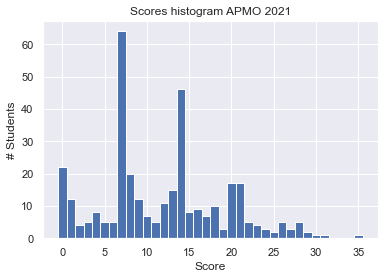

In [14]:
sns.set(color_codes=True)

plt.hist(st.total, bins=range(0,37), align='left')
plt.xlabel('Score')
plt.ylabel('# Students')
plt.title('Scores histogram APMO %s' % year)
plt.savefig('reports/histogram_%s.png' % year,dpi=120,transparent=True)
plt.show()

Now we create histograms for each problem. We use once again the `prob_cols` variable. We use `.title()` for better formatting

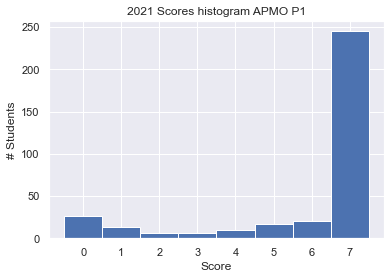

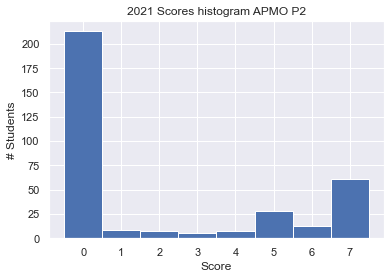

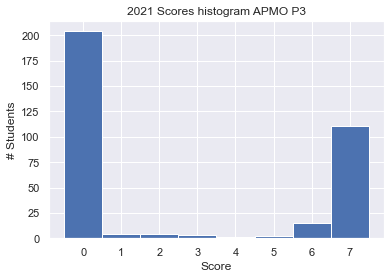

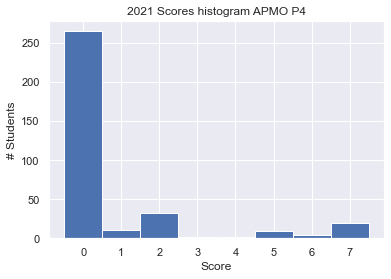

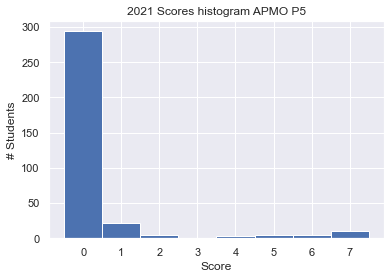

In [15]:
sns.set(color_codes=True)

for prob in prob_cols:
    plt.hist(st[prob], bins=range(0,9), align='left')
    plt.xlabel('Score')
    plt.ylabel('# Students')
    plt.title('%s Scores histogram APMO %s'% (year, prob.title()))
    plt.savefig('reports/histogram_%s_%s.png' % (prob, year),dpi=120,transparent=True)
    plt.show()

Finally, we export the information of the competition to JSON format. This will be later read by a `flask` app and sent to a `jinja2` template.

In [16]:
competition_info={'num_contestants':num_contestants, 'num_countries':num_countries, 'num_awards':num_awards,
                 'gold':int(np.ceil(gold)), 'silver':int(np.ceil(silver)), 'bronze':int(np.ceil(bronze)),
                 'mean':meanAPMO, 'std':stdAPMO, 'g_awd':g_awd, 's_awd':s_awd, 'b_awd':b_awd, 'h_men':h_men}

# We calculate the mean and std for each problem
p_means = [np.mean(st[prob]) for prob in prob_cols]
p_stds = [np.std(st[prob]) for prob in prob_cols]
competition_info['p_means']=p_means
competition_info['p_stds']=p_stds

# We dump the JSON
    
with open('reports/apmo_%s_info.json' % year, 'w') as fp:
    json.dump(competition_info, fp)